In [1]:
import rasterio
import numpy as np
from PIL import Image
import os

stacked_dir = r"C:\Users\wasif\Desktop\stacked_images"
output_dir = r"C:\Users\wasif\Desktop\RGB_IMAGES"
os.makedirs(output_dir, exist_ok=True)

def normalize(band):
    return ((band - band.min()) / (band.max() - band.min() + 1e-6) * 255).astype(np.uint8)

# Loop through all stacked images
for filename in os.listdir(stacked_dir):
    if filename.endswith("_stacked.jp2"):
        image_path = os.path.join(stacked_dir, filename)
        image_name = os.path.splitext(filename)[0].replace("_stacked", "")
        output_path = os.path.join(output_dir, f"{image_name}_RGB.png")

        with rasterio.open(image_path) as src:
            B4 = src.read(4)
            B3 = src.read(3)
            B2 = src.read(2)

        rgb = np.stack([normalize(B4), normalize(B3), normalize(B2)], axis=-1)
        Image.fromarray(rgb).save(output_path)

        print(f"✅ Saved: {output_path}")


✅ Saved: C:\Users\wasif\Desktop\RGB_IMAGES\Image_10_RGB.png
✅ Saved: C:\Users\wasif\Desktop\RGB_IMAGES\Image_12_RGB.png
✅ Saved: C:\Users\wasif\Desktop\RGB_IMAGES\Image_13_RGB.png
✅ Saved: C:\Users\wasif\Desktop\RGB_IMAGES\Image_14_RGB.png
✅ Saved: C:\Users\wasif\Desktop\RGB_IMAGES\Image_15_RGB.png
✅ Saved: C:\Users\wasif\Desktop\RGB_IMAGES\Image_16_RGB.png
✅ Saved: C:\Users\wasif\Desktop\RGB_IMAGES\Image_17_RGB.png
✅ Saved: C:\Users\wasif\Desktop\RGB_IMAGES\Image_18_RGB.png
✅ Saved: C:\Users\wasif\Desktop\RGB_IMAGES\Image_19_RGB.png
✅ Saved: C:\Users\wasif\Desktop\RGB_IMAGES\Image_1_RGB.png
✅ Saved: C:\Users\wasif\Desktop\RGB_IMAGES\Image_20_RGB.png
✅ Saved: C:\Users\wasif\Desktop\RGB_IMAGES\Image_21_RGB.png
✅ Saved: C:\Users\wasif\Desktop\RGB_IMAGES\Image_22_RGB.png
✅ Saved: C:\Users\wasif\Desktop\RGB_IMAGES\Image_23_RGB.png
✅ Saved: C:\Users\wasif\Desktop\RGB_IMAGES\Image_24_RGB.png
✅ Saved: C:\Users\wasif\Desktop\RGB_IMAGES\Image_26_RGB.png
✅ Saved: C:\Users\wasif\Desktop\RGB_IMAGE

In [2]:
import os
import numpy as np
import rasterio
from PIL import Image
import albumentations as A

# ----------- Config ----------
stacked_img_path = r"C:\Users\wasif\Desktop\Annotated Images\stacked\Image_1_stacked.jp2"
mask_path = r"C:\Users\wasif\Desktop\Annotated Images\masks_resized\Image_1_annotated_resized.png"

output_img_dir = r"C:\Users\wasif\Desktop\AugTest\images"
output_mask_dir = r"C:\Users\wasif\Desktop\AugTest\masks"
os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

N_AUGS = 5
# ------------------------------

# Albumentations transform
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30, border_mode=0, p=0.4)
])

# Load stacked image
with rasterio.open(stacked_img_path) as src:
    img_stack = src.read()  # (bands, H, W)
    meta = src.meta

img_stack_np = np.moveaxis(img_stack, 0, -1)  # (H, W, bands)
mask_np = np.array(Image.open(mask_path).convert("L"))

for i in range(N_AUGS):
    augmented = transform(image=img_stack_np, mask=mask_np)
    aug_img = np.moveaxis(augmented["image"], -1, 0)  # back to (bands, H, W)
    aug_mask = (augmented["mask"] > 127).astype(np.uint8) * 255

    # NDWI check
    B3 = aug_img[2]
    B8 = aug_img[7]
    ndwi = (B3 - B8) / (B3 + B8 + 1e-6)
    ndwi_ratio = np.sum(ndwi > 0.1) / ndwi.size
    land_ratio = np.sum(ndwi < -0.1) / ndwi.size

    if ndwi_ratio > 0.7:
        label = "water"
    elif land_ratio > 0.7:
        label = "land"
    else:
        label = "mixed"

    # Save image as JP2
    img_out_path = os.path.join(output_img_dir, f"Image_1_{label}_aug{i}.jp2")
    with rasterio.open(
        img_out_path, "w",
        driver="JP2OpenJPEG",
        height=aug_img.shape[1],
        width=aug_img.shape[2],
        count=aug_img.shape[0],
        dtype=aug_img.dtype,
        crs=meta["crs"],
        transform=meta["transform"]
    ) as dst:
        dst.write(aug_img)

    # Save mask
    mask_out_path = os.path.join(output_mask_dir, f"Image_1_{label}_aug{i}.png")
    Image.fromarray(aug_mask).save(mask_out_path)

    print(f"✅ Saved: {img_out_path} & {mask_out_path}")

print("\n🎉 Done augmenting one image + mask (saved as JP2 + PNG)!")


✅ Saved: C:\Users\wasif\Desktop\AugTest\images\Image_1_water_aug0.jp2 & C:\Users\wasif\Desktop\AugTest\masks\Image_1_water_aug0.png
✅ Saved: C:\Users\wasif\Desktop\AugTest\images\Image_1_water_aug1.jp2 & C:\Users\wasif\Desktop\AugTest\masks\Image_1_water_aug1.png
✅ Saved: C:\Users\wasif\Desktop\AugTest\images\Image_1_water_aug2.jp2 & C:\Users\wasif\Desktop\AugTest\masks\Image_1_water_aug2.png
✅ Saved: C:\Users\wasif\Desktop\AugTest\images\Image_1_water_aug3.jp2 & C:\Users\wasif\Desktop\AugTest\masks\Image_1_water_aug3.png
✅ Saved: C:\Users\wasif\Desktop\AugTest\images\Image_1_water_aug4.jp2 & C:\Users\wasif\Desktop\AugTest\masks\Image_1_water_aug4.png

🎉 Done augmenting one image + mask (saved as JP2 + PNG)!


c:\Users\wasif\AppData\Local\Programs\Python\Python313\Lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (120560400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


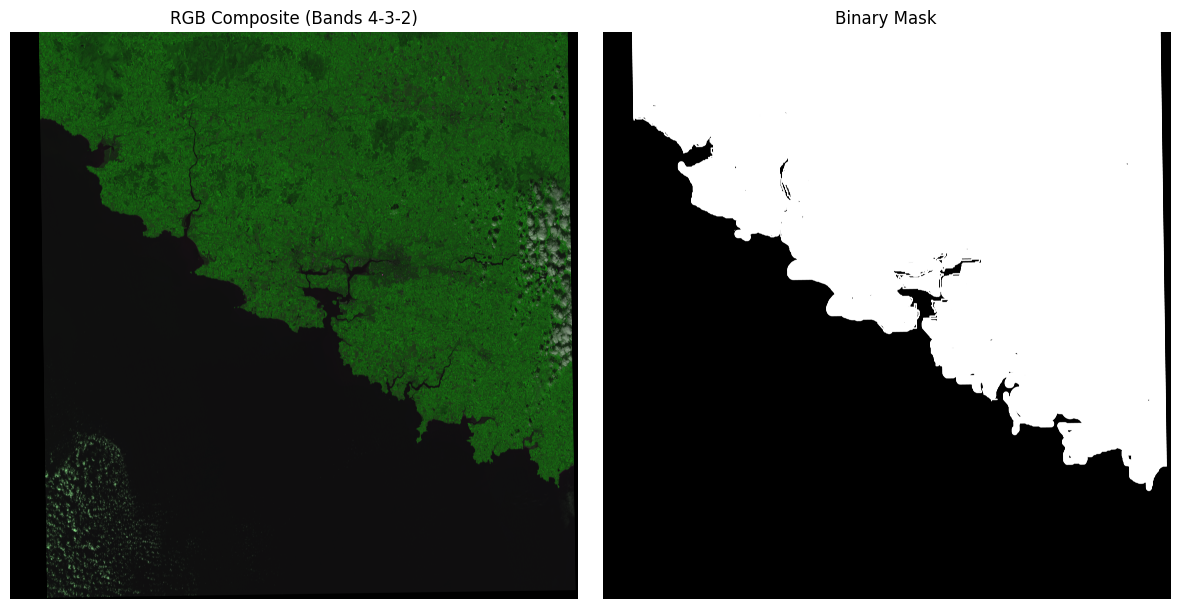

In [4]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from PIL import Image

# Paths to one pair
image_path = r'c:\Users\wasif\Desktop\AugTest\images\Image_1_water_aug0.jp2'
mask_path = r"C:\Users\wasif\Desktop\AugTest\masks\Image_1_water_aug0.png"

# Load image
with rasterio.open(image_path) as src:
    image_data = src.read()  # (bands, H, W)

# Select RGB bands (B04 = Red, B03 = Green, B02 = Blue)
B4 = image_data[3]  # Red
B3 = image_data[2]  # Green
B2 = image_data[1]  # Blue

# Normalize for visualization
def normalize(band):
    return (band - band.min()) / (band.max() - band.min() + 1e-6)

rgb = np.stack([normalize(B4), normalize(B3), normalize(B2)], axis=-1)

# Load mask
mask = np.array(Image.open(mask_path))

# Display
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.title("RGB Composite (Bands 4-3-2)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Binary Mask")
plt.axis("off")

plt.tight_layout()
plt.show()
